>>> INICIANDO PIPELINE DE DATA SCIENCE <<<
[ETL] Arquivo CSV já existe. Carregando direto.

=== 2. Análise Exploratória de Dados (EDA) ===
Proporção de Classes:
Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64
-> Gerando Matriz de Correlação...


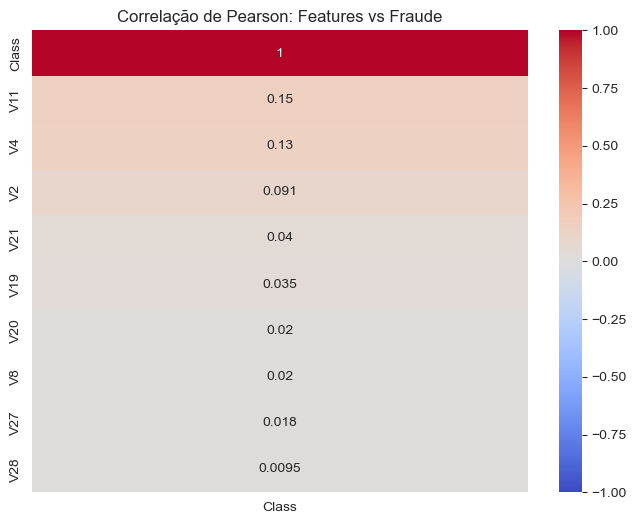

-> Analisando Distinção de Distribuições (Boxplots)...


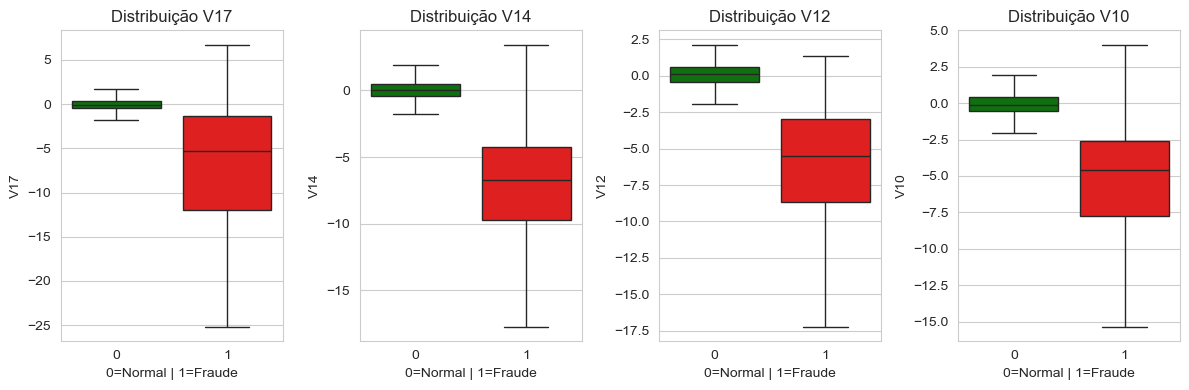


=== 3. Amostragem (Train/Test Split) ===
Tamanho Treino: 199364 | Tamanho Teste: 85443

=== 4. Treinamento do Modelo ===
Treinando Random Forest com pesos balanceados (Aguarde)...

=== 5. Avaliação e Otimização de Decisão ===
>>> Threshold Otimizado (Maximiza F1): 0.5396


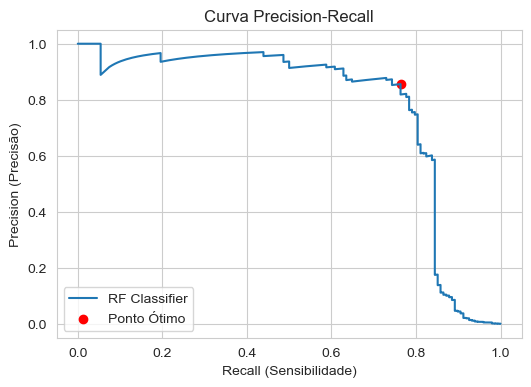


Relatório Final (Com Threshold Otimizado):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.86      0.76      0.81       148

    accuracy                           1.00     85443
   macro avg       0.93      0.88      0.90     85443
weighted avg       1.00      1.00      1.00     85443



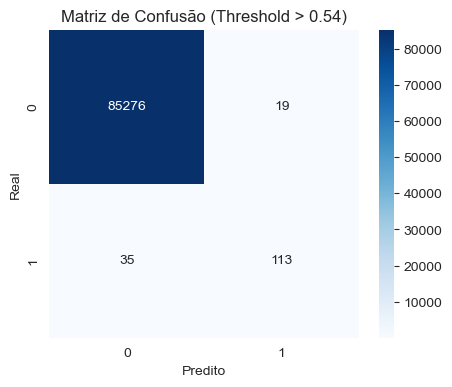


=== 6. Interpretabilidade do Modelo (SHAP) ===


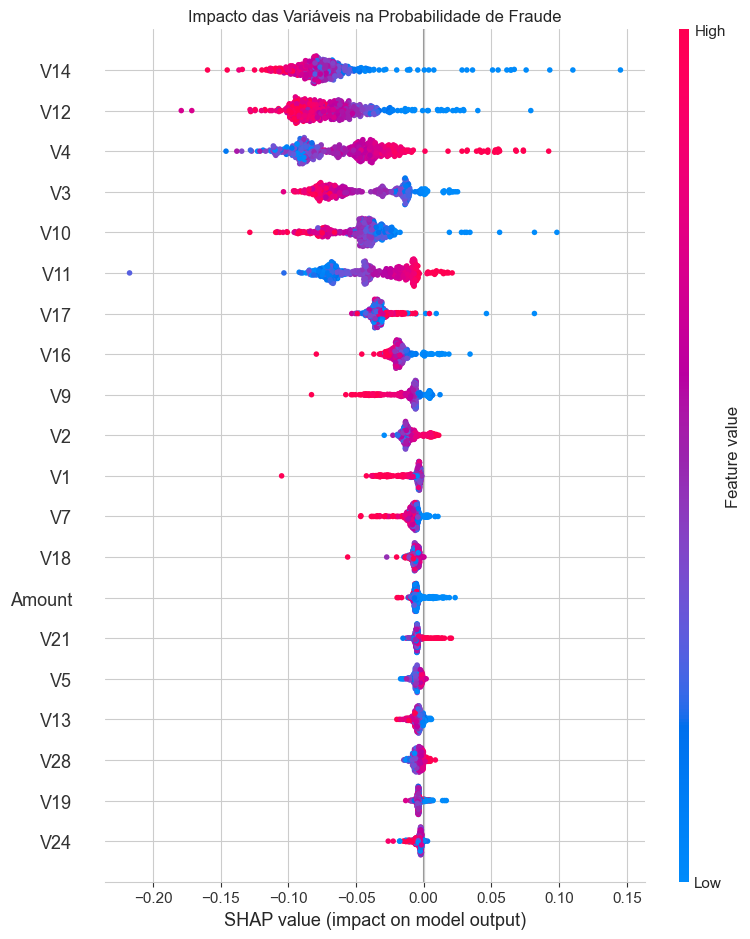


>>> PROJETO FINALIZADO COM SUCESSO <<<


In [5]:
'''
PROJETO: Detecção de Fraude em Transações Bancárias
AUTOR: Estudante de Estatística (3º Semestre)
OBJETIVO: Identificar anomalias (fraudes) em dataset desbalanceado
          utilizando inferência visual e otimização de limiar de decisão.
'''

import os
import zipfile
import pandas as pd
import numpy as np

# --- Bibliotecas para Modelagem e Estatística ---
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    confusion_matrix,
    precision_recall_curve,
    f1_score
)

# --- Bibliotecas de Visualização ---
import matplotlib.pyplot as plt
import seaborn as sns

# Configuração de estilo para gráficos acadêmicos
sns.set_style("whitegrid")

# =====================================================
# CONFIGURAÇÕES GERAIS & CAMINHOS
# =====================================================
RANDOM_STATE = 42
TEST_SIZE = 0.30  # 30% para teste (amostra hold-out)

# Caminhos (Ajustados para a raiz do projeto)
DATA_RAW_DIR = os.path.join('data', 'raw')
DATA_PROCESSED_DIR = os.path.join('data', 'processed')

# IMPORTANTE: O código busca 'dados.zip' na pasta 'data/raw'
ZIP_FILE = os.path.join(DATA_RAW_DIR, 'dados.zip')
CSV_FILE = os.path.join(DATA_PROCESSED_DIR, 'creditcard.csv')

# =====================================================
# 1. COLETA E PRÉ-PROCESSAMENTO
# =====================================================
def extract_data(zip_path: str, extract_to: str):
    """Extrai os dados se o CSV não existir."""
    if not os.path.exists(zip_path):
        raise FileNotFoundError(f"Arquivo ZIP não encontrado em: {os.path.abspath(zip_path)}")
    
    if not os.path.exists(os.path.join(extract_to, 'creditcard.csv')):
        print(f"[ETL] Extraindo {zip_path}...")
        os.makedirs(extract_to, exist_ok=True)
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
    else:
        print("[ETL] Arquivo CSV já existe. Carregando direto.")

def load_dataset(csv_path: str) -> pd.DataFrame:
    return pd.read_csv(csv_path)

# =====================================================
# 2. ANÁLISE EXPLORATÓRIA (EDA) - VIÉS ESTATÍSTICO
# =====================================================
def exploratory_analysis(df: pd.DataFrame) -> None:
    print("\n=== 2. Análise Exploratória de Dados (EDA) ===")
    
    # Verificando desbalanceamento de classes
    prop = df['Class'].value_counts(normalize=True)
    print(f"Proporção de Classes:\n{prop}")
    
    # --- A. Análise de Correlação (Heatmap) ---
    print("-> Gerando Matriz de Correlação...")
    plt.figure(figsize=(8, 6))
    
    # numeric_only=True evita erros em versões novas do Pandas
    corr = df.corr(numeric_only=True)
    
    # Focamos na correlação com a variável target ('Class')
    sns.heatmap(corr[['Class']].sort_values(by='Class', ascending=False).head(10), 
                annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title("Correlação de Pearson: Features vs Fraude")
    plt.show()

    # --- B. Comparação de Distribuições (Boxplots) ---
    # Hipótese: Fraudes têm comportamento divergente em V17, V14, V12 e V10
    print("-> Analisando Distinção de Distribuições (Boxplots)...")
    cols_to_check = ['V17', 'V14', 'V12', 'V10']
    
    plt.figure(figsize=(12, 4))
    for i, col in enumerate(cols_to_check):
        plt.subplot(1, 4, i+1)
        
        # CORREÇÃO DO ERRO SEABORN:
        # Usamos hue='Class' e passamos a palette como lista simples
        sns.boxplot(
            x="Class", 
            y=col, 
            hue="Class", 
            data=df, 
            palette=["g", "r"], # Verde para normal, Vermelho para fraude
            legend=False, 
            showfliers=False
        )
        
        plt.title(f"Distribuição {col}")
        plt.xlabel("0=Normal | 1=Fraude")
    plt.tight_layout()
    plt.show()

# =====================================================
# 3. PREPARAÇÃO DA AMOSTRA
# =====================================================
def prepare_data(df: pd.DataFrame):
    print("\n=== 3. Amostragem (Train/Test Split) ===")
    X = df.drop(columns=['Class'])
    y = df['Class']

    # Uso de estratificação para manter a proporção de fraudes (0.17%) nas amostras
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
    )
    print(f"Tamanho Treino: {X_train.shape[0]} | Tamanho Teste: {X_test.shape[0]}")
    return X_train, X_test, y_train, y_test

# =====================================================
# 4. MODELAGEM (PIPELINE)
# =====================================================
def train_model(X_train, y_train):
    print("\n=== 4. Treinamento do Modelo ===")
    
    # Pipeline: Garante que a normalização (StandardScaler) seja ajustada APENAS no treino
    # evitando 'Data Leakage' (vazamento de dados) estatístico.
    pipeline = Pipeline([
        ('scaler', StandardScaler()), 
        ('clf', RandomForestClassifier(
            n_estimators=100,
            max_depth=10,            # Evita Overfitting
            class_weight='balanced', # Penaliza erros na classe minoritária
            random_state=RANDOM_STATE,
            n_jobs=-1
        ))
    ])
    
    print("Treinando Random Forest com pesos balanceados (Aguarde)...")
    pipeline.fit(X_train, y_train)
    return pipeline

# =====================================================
# 5. AVALIAÇÃO E INFERÊNCIA (OTIMIZAÇÃO DE THRESHOLD)
# =====================================================
def evaluate_model(pipeline, X_test, y_test) -> None:
    print("\n=== 5. Avaliação e Otimização de Decisão ===")
    
    # Obtemos as probabilidades (score de propensão à fraude)
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    
    # Curva Precision-Recall
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
    
    # --- Otimização ---
    # Buscamos o Threshold que maximiza o F1-Score (média harmônica entre Precision e Recall)
    # Adicionamos 1e-10 para evitar divisão por zero
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
    
    print(f">>> Threshold Otimizado (Maximiza F1): {best_threshold:.4f}")
    
    # Plot da Curva PR
    plt.figure(figsize=(6, 4))
    plt.plot(recalls, precisions, label='RF Classifier')
    plt.scatter(recalls[best_idx], precisions[best_idx], marker='o', color='red', label='Ponto Ótimo')
    plt.xlabel('Recall (Sensibilidade)')
    plt.ylabel('Precision (Precisão)')
    plt.title('Curva Precision-Recall')
    plt.legend()
    plt.show()
    
    # Matriz de Confusão com o novo corte
    y_pred_opt = (y_proba >= best_threshold).astype(int)
    
    print("\nRelatório Final (Com Threshold Otimizado):")
    print(classification_report(y_test, y_pred_opt))
    
    plt.figure(figsize=(5, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred_opt), annot=True, fmt='d', cmap='Blues')
    plt.title(f"Matriz de Confusão (Threshold > {best_threshold:.2f})")
    plt.ylabel("Real")
    plt.xlabel("Predito")
    plt.show()

# =====================================================
# 6. INTERPRETABILIDADE (SHAP)
# =====================================================
def explain_model(pipeline, X_sample):
    print("\n=== 6. Interpretabilidade do Modelo (SHAP) ===")
    try:
        import shap
        shap.initjs()
        
        # Acessamos os passos internos do Pipeline
        model = pipeline.named_steps['clf']
        scaler = pipeline.named_steps['scaler']
        
        # Transformamos os dados (escala Z) antes de explicar
        X_sample_scaled = scaler.transform(X_sample)
        
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_sample_scaled, check_additivity=False)
        
        # Ajuste de formato para plotagem (Lista vs Array)
        if isinstance(shap_values, list):
            vals = shap_values[1]
        elif len(shap_values.shape) == 3:
            vals = shap_values[:, :, 1]
        else:
            vals = shap_values
            
        plt.title("Impacto das Variáveis na Probabilidade de Fraude")
        shap.summary_plot(vals, X_sample_scaled, feature_names=X_sample.columns)
        
    except Exception as e:
        print(f"SHAP não pode ser gerado: {e}")

# =====================================================
# EXECUÇÃO PRINCIPAL
# =====================================================
def main():
    print(">>> INICIANDO PIPELINE DE DATA SCIENCE <<<")
    extract_data(ZIP_FILE, DATA_PROCESSED_DIR)
    df = load_dataset(CSV_FILE)
    
    exploratory_analysis(df)
    
    X_train, X_test, y_train, y_test = prepare_data(df)
    
    pipeline = train_model(X_train, y_train)
    
    evaluate_model(pipeline, X_test, y_test)
    
    # Amostra reduzida para explicação rápida (500 observações)
    explain_model(pipeline, X_test.sample(500, random_state=RANDOM_STATE))
    
    print("\n>>> PROJETO FINALIZADO COM SUCESSO <<<")

if __name__ == '__main__':
    main()